In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_spectrum(spectrum_values, save_path=None, dpi=300, fig_width=10, fig_height=6, 
                  highlight_extremes=True, max_display_points=1000):
    """
    Creates a publication-quality plot for spectrum values visualization, scalable for large datasets.
    Highlights the smallest, second smallest, and largest eigenvalues.
    
    Parameters:
    -----------
    spectrum_values : list or array
        The spectrum values to visualize.
    save_path : str, optional
        Path to save the figure. If None, the figure is displayed but not saved.
    dpi : int, optional
        Resolution of the saved figure in dots per inch.
    fig_width : float, optional
        Width of the figure in inches.
    fig_height : float, optional
        Height of the figure in inches.
    highlight_extremes : bool, optional
        Whether to highlight the extreme values (smallest, second smallest, largest).
    max_display_points : int, optional
        Maximum number of points to display individually. For larger datasets,
        a different visualization approach will be used.
    
    Returns:
    --------
    fig, ax : tuple
        Figure and axes objects for further customization if needed.
    """
    
    # Set publication-quality parameters
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
        'font.size': 14,
        'axes.linewidth': 0.8,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'legend.frameon': False,
        'legend.handlelength': 1.5,
        'legend.handletextpad': 0.5
    })
    
    # Convert to numpy array if it's not already
    spectrum = np.array(spectrum_values)
    total_points = len(spectrum)
    
    # Sort the spectrum if not already sorted
    is_sorted = np.all(np.diff(spectrum) >= 0)
    if not is_sorted:
        sorted_spectrum = np.sort(spectrum)
    else:
        sorted_spectrum = spectrum
        
    # Find the indices and values of interest
    smallest_val = sorted_spectrum[0]
    second_smallest_val = sorted_spectrum[1]
    largest_val = sorted_spectrum[-1]
    
    # Find original indices if we need them
    if highlight_extremes:
        smallest_idx = np.where(spectrum == smallest_val)[0][0]
        second_smallest_idx = np.where(spectrum == second_smallest_val)[0][0]
        largest_idx = np.where(spectrum == largest_val)[0][0]
    
    # Determine if we need a different visualization strategy
    needs_decimation = total_points > max_display_points
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    # Set smoke gray background for plotting area
    ax.set_facecolor('#f0f0f0')  # Light smoke gray
    
    # Define a professional color palette (colorblind-friendly)
    colors = {'main': '#0173B2', 'highlight': '#DE8F05', 'special': '#029E73', 'largest': '#CC0000'}
    
    if needs_decimation:
        # For large datasets, we'll use a different approach
        
        # Plot a subset of points but keep distribution
        if total_points > max_display_points:
            # Calculate how many points to skip
            skip = total_points // max_display_points
            
            # Create a downsampled version that preserves distribution
            indices = np.linspace(0, total_points-1, max_display_points, dtype=int)
            downsampled_spectrum = spectrum[indices]
            
            # Plot downsampled data
            ax.plot(indices, downsampled_spectrum, '-', color=colors['main'], 
                    linewidth=0.8, alpha=0.7, label=f"Spectrum Values (downsampled, n={total_points})")
            
            # Option: Add scatter for downsampled points
            # ax.scatter(indices, downsampled_spectrum, color=colors['main'], s=3, alpha=0.3)
            
            # Create a secondary plot showing the density
            ax_density = ax.twinx()
            
            # Create a proper histogram
            hist_bins = min(100, total_points // 100)
            hist, bin_edges = np.histogram(spectrum, bins=hist_bins)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            # Plot density as a filled curve on secondary y-axis
            if False:
                ax_density.fill_between(bin_centers, hist, alpha=0.3, color='gray')
                ax_density.set_ylabel('Density', color='gray', fontweight='bold')
                ax_density.tick_params(axis='y', colors='gray')
                ax_density.spines['right'].set_visible(True)
                ax_density.spines['right'].set_color('gray')
            
                # Make the density axis less prominent
                ax_density.set_zorder(-1)
            
            # Set x-axis to represent indices
            ax.set_xlabel("Index", fontweight='bold')
            ax.set_ylabel("Eigenvalue", fontweight='bold')
            
            # Set reasonable tick frequency based on downsampled data
            tick_step = max(1, len(indices) // 10)
            tick_positions = indices[::tick_step]
            tick_labels = [f"{i}" for i in tick_positions]
            ax.set_xticks(tick_positions)
            ax.set_xticklabels(tick_labels)
            
        else:
            # This block shouldn't be reached, but just in case
            ax.plot(range(total_points), spectrum, '-', color=colors['main'], 
                    linewidth=1.0, alpha=0.7, label="Spectrum values")
    else:
        # For smaller datasets, plot all points
        ax.plot(range(total_points), spectrum, '-', color=colors['main'], 
                linewidth=1.0, alpha=0.7, label="Spectrum Values")
        ax.scatter(range(total_points), spectrum, color=colors['main'], 
                   s=20, alpha=0.5, edgecolor='none')
        
        # Set x-axis ticks for smaller datasets
        if total_points <= 10:
            ax.set_xticks(range(total_points))
        elif total_points <= 20:
            ax.set_xticks(range(0, total_points, 2))
        else:
            step = max(1, total_points // 10)
            ax.set_xticks(range(0, total_points, step))
    
    # Always highlight the key eigenvalues regardless of dataset size
    if highlight_extremes:
        # Add markers for the extremes
        highlighted_points = [
            (smallest_idx, smallest_val, "Smallest", colors['highlight']),
            (second_smallest_idx, second_smallest_val, "2nd Smallest", colors['special']),
            (largest_idx, largest_val, "Largest", colors['largest'])
        ]
        
        for idx, val, label, color in highlighted_points:
            ax.scatter(idx, val, s=100, color=color, zorder=10, 
                       edgecolor='black', linewidth=0.5, 
                       label=f"{label}: {val:.6f}")
            
            # Add annotations with offset based on whether value is positive or negative
            y_offset = 10 if val >= 0 else -30  
            
            if False:
                ax.annotate(f"{label}: {val:.6f}", 
                        xy=(idx, val),
                        xytext=(10, y_offset), 
                        textcoords="offset points",
                        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
                        fontsize=8, fontweight='bold')
    
    # Add title
    #ax.set_title(f"Spectrum Visualization (n={total_points})", fontweight='bold', fontsize=11)
    
    # Add grid lines, behind the data points
    ax.grid(True, linestyle='--', alpha=0.7, zorder=0)
    
    # Add a horizontal line at y=0 for reference
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, zorder=1)
    
    # Customize spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend in optimal position
    ax.legend(loc='best', frameon=True, framealpha=0.7)
    
    # Adjust y-axis limits with some padding
    value_range = np.ptp(spectrum)
    y_min = min(spectrum) - value_range * 0.05
    y_max = max(spectrum) + value_range * 0.05
    ax.set_ylim(y_min, y_max)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if path is provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    
    return fig, ax

In [2]:
def visualize_differences(differences, save_path=None):
    """
    Visualizes the variance of spectrum differences as a line plot.

    Parameters:
    -----------
    differences : list
        List of variance values for spectrum differences.
    save_path : str, optional
        Path to save the figure. If None, the figure is displayed but not saved.
    """
    # Set publication-quality parameters
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
        'font.size': 14,
        'axes.linewidth': 0.8,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'legend.frameon': False,
        'legend.handlelength': 1.5,
        'legend.handletextpad': 0.5
    })
    
    # Define a professional color palette
    colors = {'main': '#0173B2', 'highlight': '#DE8F05', 'special': '#029E73', 'largest': '#CC0000'}
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_facecolor('#f0f0f0')  # Light smoke gray background
    ax.plot(differences, '-o', color=colors['main'], linewidth=2.0, markersize=8, 
            markerfacecolor=colors['highlight'], markeredgecolor='black')
    ax.set_yscale('log')
    ax.set_xticks(range(len(differences)))
    ax.set_xticklabels(range(6, 6 + len(differences)))
    ax.set_xlabel("Number of qubits", fontweight='bold')
    ax.set_ylabel("Variance of differences in spectrum", fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save or show the plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()


Loaded 100 cases.
Found 10 cases with 6 qubits.
Loaded 100 cases.
Found 10 cases with 6 qubits.
Found 10 cases with 7 qubits.
Loaded 100 cases.
Found 10 cases with 7 qubits.
Found 10 cases with 8 qubits.
Loaded 100 cases.
Found 10 cases with 8 qubits.
Found 10 cases with 9 qubits.
Loaded 100 cases.
Found 10 cases with 9 qubits.
Found 10 cases with 10 qubits.
Loaded 100 cases.
Found 10 cases with 10 qubits.
Found 10 cases with 11 qubits.
Loaded 100 cases.
Found 10 cases with 11 qubits.
Found 10 cases with 12 qubits.
Loaded 100 cases.
Found 10 cases with 12 qubits.
Found 10 cases with 13 qubits.
Loaded 100 cases.
Found 10 cases with 13 qubits.


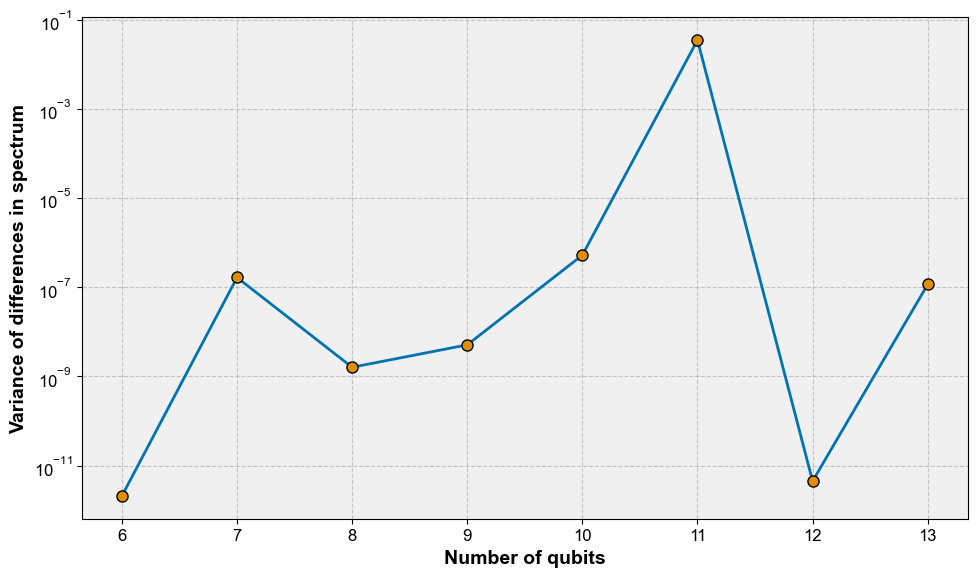

In [3]:
import json
import os

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)
    
data = {}
# Get file names like portfolio_optimization_results_batch_ from the parent directory
files = [file for file in os.listdir("../cmaes_qubo_mean_variance_results/") if "portfolio_optimization_results_batch_" in file]
for file in files:
    data.update(load_json("../cmaes_qubo_mean_variance_results/" + file))

print(f"Loaded {len(data)} cases.")

differences = []
for fixed_q in range(6, 14):
    cases = [i for i in data if data[i]['hyperparams']['n_qubits'] == fixed_q]
    print(f"Found {len(cases)} cases with {fixed_q} qubits.")

    data2 = {}
    files2 = [file for file in os.listdir("../cmaes_hubo_results/") if "portfolio_optimization_results_batch_" in file]
    for file in files2:
        data2.update(load_json("../cmaes_hubo_results/" + file))

    print(f"Loaded {len(data2)} cases.")

    cases2 = [i for i in data if data2[i]['hyperparams']['n_qubits'] == fixed_q]
    print(f"Found {len(cases2)} cases with {fixed_q} qubits.")

    # Select a random case
    i = cases2[1]

    spectrum = data[i]['exact_solution']['spectrum']
    spectrum2 = data2[i]['exact_solution']['spectrum']

    diff = []
    for s1, s2 in zip(spectrum, spectrum2):
        #print(np.abs(s1 - s2))
        diff.append(np.abs(s1 - s2))
    
    differences.append(np.var(diff))


# Call the function to visualize the differences
visualize_differences(differences, save_path="variance_spectrum_differences.png")
    

# Call the function to visualize the spectrum
#fig, ax = plot_spectrum(diff, save_path=f"spectrum_plot_mean_variance_diff_{fixed_q}.png")
#fig2, ax2 = plot_spectrum(spectrum2, save_path=f"spectrum_plot_{fixed_q}.png")
#plt.show()